In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import scipy.stats 
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn import preprocessing, linear_model, svm, ensemble, cross_validation, metrics
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

# Data Collection

Census block group data (2015 ACS 5-year) was collected for all neighborhoods in Douglas County. Information collected was in regards to neighborhood size, race, age, family type, income, homeownership, home values, home construction dates, and how long residents have lived in the neighborhood. The data for all neighborhoods was compared with Trendwood using the nearest neighbors algorithm to determine six neighborhoods that are most similar to Trendwood socially, economically, and residentially. The most similar neighborhoods to Trendwood are Western Trails, North Oaks, Deer Ridge, Stonehenge, Meadow Lane, and Timber Creek/Holling Heights.

In [2]:
pd.read_excel('subdivisions.xlsx').transpose()

,0,1,2,3,4,5,6
neighborhood,TRENDWOOD,WESTERN TRAILS,NORTH OAKS,DEER RIDGE,STONEHENGE,MEADOW LANE,TIMBER CREEK / HOLLING HEIGHTS
state,NE,NE,NE,NE,NE,NE,NE
county,Douglas County,Douglas County,Douglas County,Douglas County,Douglas County,Douglas County,Douglas County
state_fips,31,31,31,31,31,31,31
county_fips,55,55,55,55,55,55,55
tract,7406,7450,7312,7448,7442,6703,7463
block group,4,3,1,1,5,3,3
total population,1100,961,1207,866,781,997,1026
white,1,0.967742,0.835957,0.959584,0.8758,0.984955,0.982456
black,0,0,0.0753935,0.0150115,0.0102433,0,0.00682261


Sales data for these neighborhoods was collected from dcassessor.org on 4/17/2017 for sales beginning 1/1/2007. For parcels that had sales, parcel features were collected. The sales data and parcels data was joined together to create the data used for this analysis. 

In [3]:
df = pd.read_csv('sales_and_parcels.csv', parse_dates=[1])

In [4]:
print('\nDATA COLLECTED:\n')
for col in df.columns:
    print(col + ' / ', end='')


DATA COLLECTED:

account / sales_date / deed_type / sales_price / grantor / grantee / sale_validity / owner / key_number / account_type / parcel_number / parcel_address / legal_description / land_value_2012 / improvement_value_2012 / total_value_2012 / land_value_2013 / improvement_value_2013 / total_value_2013 / land_value_2014 / improvement_value_2014 / total_value_2014 / land_value_2015 / improvement_value_2015 / total_value_2015 / land_value_2016 / improvement_value_2016 / total_value_2016 / land_value_2017 / improvement_value_2017 / total_value_2017 / image_url / square_feet / perimeter / unit_type / built_as / hvac / exterior / interior / roof_cover / roof_type / floor_cover / percent_complete / quality / condition / condo_square_feet / rooms / units / baths / bedrooms / stories / foundation / sprinkler_square_feet / year_built / year_remodeled / percent_remodeled / adjusted_year_built / physical_age / latitude / longitude / acres / land_square_feet / depth / width / vacant / 0 

# Identify Trend in Sales Price

### Plotting sales price vs time

In [5]:
min_date = min(df.sales_date)

In [6]:
df['days_from_start'] = df.sales_date.apply(lambda x: float((x - min_date).days))

In [7]:
X = df.days_from_start.values

In [8]:
y = df.sales_price.values

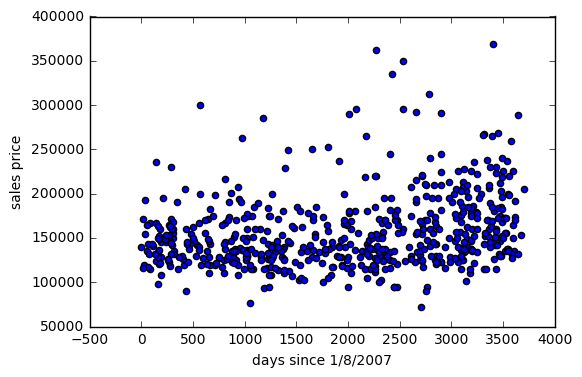

In [9]:
plt.scatter(X, y)
plt.ylabel('sales price')
plt.xlabel('days since %d/%d/%d' % (min_date.month, min_date.day, min_date.year))
plt.show()

### Identifying sales price trend over time

In [10]:
for i in range(1,10):
    poly = preprocessing.PolynomialFeatures(i)
    X_poly = poly.fit_transform(X.reshape(-1, 1))
    model = linear_model.LinearRegression()
    model.fit(X_poly, y)
    print(i, model.score(X_poly, y))

1 0.0613085037701
2 0.0728732522796
3 0.0728917904831
4 0.0730773562901
5 0.0733411378049
6 0.0739192801296
7 0.073735888776
8 0.0733348176731
9 0.0732943100573


In [11]:
poly = preprocessing.PolynomialFeatures(6)
model = linear_model.LinearRegression()

X_trend = poly.fit_transform(X.reshape(-1, 1))
model.fit(X_trend,y)

days_range = np.array(range(int(min(X)),int(max(X))+1))
days_poly = poly.fit_transform(days_range.reshape(-1,1))
trend = model.predict(days_poly)

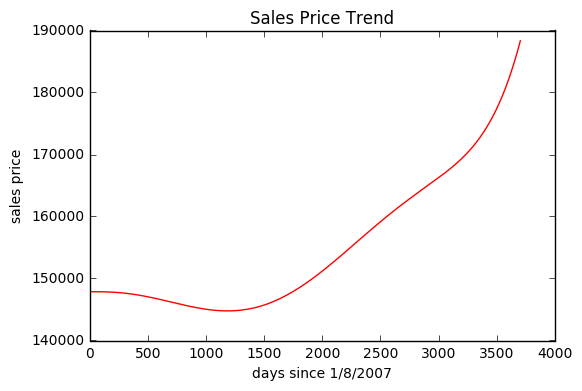

In [12]:
plt.plot(days_range, trend, color='r')
plt.ylabel('sales price')
plt.xlabel('days since %d/%d/%d' % (min_date.month, min_date.day, min_date.year))
plt.title('Sales Price Trend')
plt.show()

### Overlaying trendline onto sales data

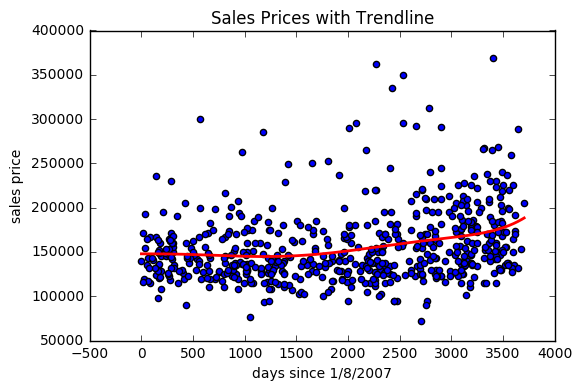

In [13]:
plt.scatter(X, y)
plt.plot(days_range, trend, color='r', lw=2)
plt.ylabel('sales price')
plt.xlabel('days since %d/%d/%d' % (min_date.month, min_date.day, min_date.year))
plt.title('Sales Prices with Trendline')
plt.show()

# Detrend Sales Price by Adjusting Previous Sales to Current Market

By keeping the right end of the trendline fixed and pulling it level from the left, thereby also adjusting all of the points that are fixed in relation to the trendline, we can eliminate time as a factor for our analysis. In other words, all previous sales are adjusted to current market levels so that there is no sales price trend over time and all sales can be compared in an apples to apples fashion.

In [14]:
pred_X = poly.fit_transform(max(df.days_from_start))
level_today = model.predict(pred_X)

trend = model.predict(X_trend)

In [15]:
df['adjustment'] = 1.0 / (trend / level_today)

In [16]:
df['detrended_price'] = df.sales_price * df.adjustment

In [17]:
model = linear_model.LinearRegression()
model.fit(X.reshape(-1, 1), df.detrended_price.values.reshape(-1, 1))
trend = model.predict(days_range.reshape(-1, 1))

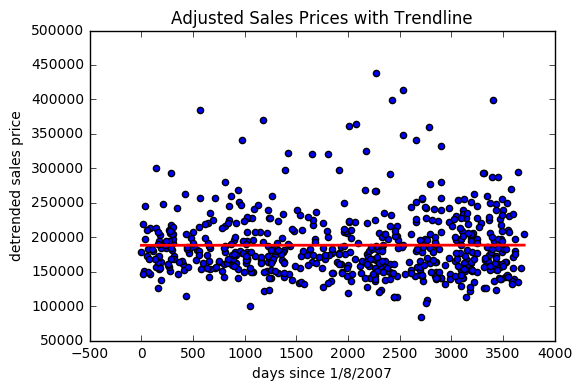

In [18]:
plt.scatter(X, df.detrended_price.values)
plt.plot(days_range, trend, color='r', lw=2)
plt.ylabel('detrended sales price')
plt.xlabel('days since %d/%d/%d' % (min_date.month, min_date.day, min_date.year))
plt.title('Adjusted Sales Prices with Trendline')
plt.show()

# Examine Relationship between SqFt and Price/SqFt

Now that all sales are as if they happened on the last day of the analysis (since sales price trend has been removed), the relationship between the size of a house and the price paid per square footage for that house can be examined.

## Base SqFt

In [19]:
df['dtrend_price_per_base_sqft'] = df.detrended_price / df.square_feet

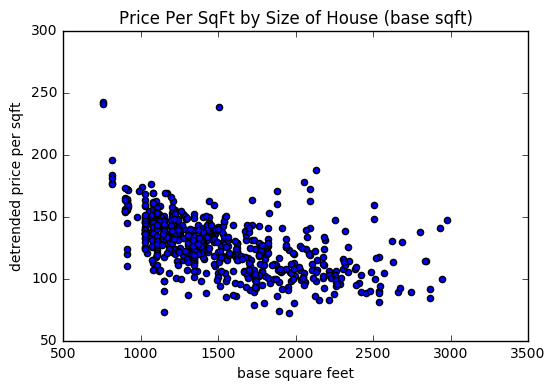

In [20]:
plt.scatter(df.square_feet.values, df.dtrend_price_per_base_sqft.values)
plt.ylabel('detrended price per sqft')
plt.xlabel('base square feet')
plt.title('Price Per SqFt by Size of House (base sqft)')
plt.show()

### Identifying line that best fits the plot points

In [21]:
X = df.square_feet.values
y = df.dtrend_price_per_base_sqft.values

for i in range(1,10):
    poly = preprocessing.PolynomialFeatures(i)
    X_poly = poly.fit_transform(X.reshape(-1, 1))
    model = linear_model.LinearRegression()
    model.fit(X_poly, y)
    print(i, model.score(X_poly, y))

1 0.29954443308
2 0.36903298942
3 0.377493434795
4 0.393309631185
5 0.385854296781
6 0.377302368334
7 0.367386691006
8 0.355833683579
9 0.342322319965


In [22]:
poly = preprocessing.PolynomialFeatures(4)
model = linear_model.LinearRegression()

X_trend = poly.fit_transform(X.reshape(-1, 1))
model.fit(X_trend,y)

sqft_range = np.array(range(int(min(X)),int(max(X))+1))
sqft_poly = poly.fit_transform(sqft_range.reshape(-1,1))
trend = model.predict(sqft_poly)

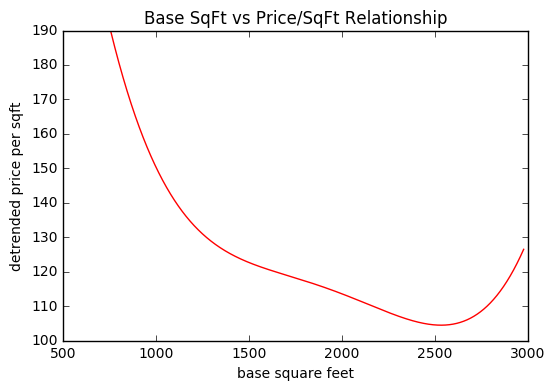

In [23]:
plt.plot(sqft_range, trend, color='r')
plt.ylabel('detrended price per sqft')
plt.xlabel('base square feet')
plt.title('Base SqFt vs Price/SqFt Relationship')
plt.show()

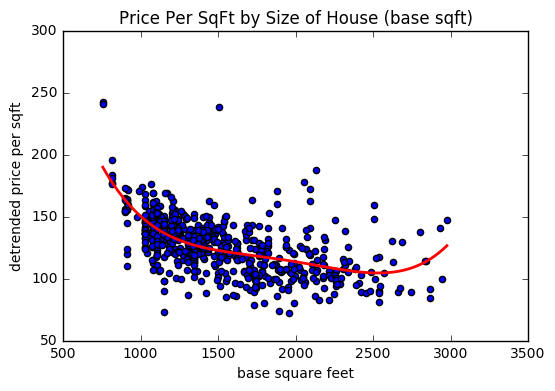

In [24]:
plt.scatter(X, y)
plt.plot(sqft_range, trend, color='r', lw=2)
plt.ylabel('detrended price per sqft')
plt.xlabel('base square feet')
plt.title('Price Per SqFt by Size of House (base sqft)')
plt.show()

### Adding ranges above and below best fit line

By examining the distance between all of the data points and the best fit line we can calculate the standard error. By using the standard error we can plot additional lines above and below the best fit line. We can also understand the percentage of points that fall between these lines.

The percentage of points that fall within each range is:
* Great: 16%
* Good: 25%
* OK, I guess 25%
* Junky: 16%

The ranges are based on the notion that two properites of the same size will sell at widely different prices if one of the properties is exceptional and the other property is in disrepair.

In [25]:
sq_error = (y - model.predict(X_trend)) ** 2
st_error = np.sqrt(np.sum(sq_error) / (len(y) - 1))

high_abv_avg = trend + st_error * 0.67449 * 2
high_avg = trend + st_error * 0.67449
low_avg = trend - st_error * 0.67449
low_bel_avg = trend - st_error * 0.67449 * 2

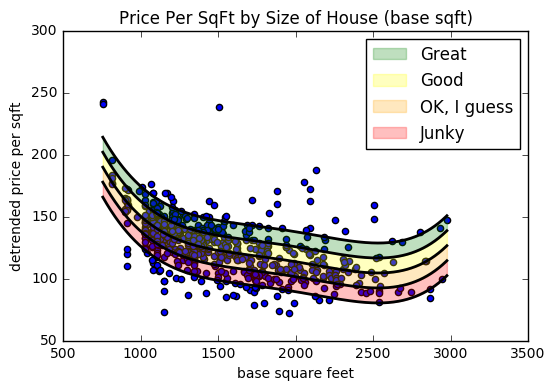

In [26]:
plt.scatter(X, y)
plt.plot(sqft_range, high_abv_avg, color='k', lw=2)
plt.plot(sqft_range, high_avg, color='k', lw=2)
plt.plot(sqft_range, trend, color='k', lw=2)
plt.plot(sqft_range, low_avg, color='k', lw=2)
plt.plot(sqft_range, low_bel_avg, color='k', lw=2)
plt.fill_between(sqft_range, high_abv_avg, high_avg, color='green', alpha=0.25)
plt.fill_between(sqft_range, high_avg, trend, color='yellow', alpha=0.25)
plt.fill_between(sqft_range, trend, low_avg, color='orange', alpha=0.25)
plt.fill_between(sqft_range, low_avg, low_bel_avg, color='red', alpha=0.25)
green_patch = mpatches.Patch(color='green', label='Great', alpha=0.25)
yellow_patch = mpatches.Patch(color='yellow', label='Good', alpha=0.25)
orange_patch = mpatches.Patch(color='orange', label='OK, I guess', alpha=0.25)
red_patch = mpatches.Patch(color='red', label='Junky', alpha=0.25)
plt.legend(handles=[green_patch, yellow_patch, orange_patch, red_patch])
plt.ylabel('detrended price per sqft')
plt.xlabel('base square feet')
plt.title('Price Per SqFt by Size of House (base sqft)')
plt.show()

### Price ranges at 1,109 BASE square feet

We can now calculate what the Great, Good, OK, and Junky ranges would be for a house based on 1,109 main floor square feet.

In [27]:
target_sqft = 1109
poly_target = poly.fit_transform(target_sqft)
ppf_3 = model.predict(poly_target)[0]
ppf_1 = ppf_3 - st_error * 0.67449 * 2
ppf_2 = ppf_3 - st_error * 0.67449
ppf_4 = ppf_3 + st_error * 0.67449
ppf_5 = ppf_3 + st_error * 0.67449 * 2
price_1 = ppf_1 * target_sqft
price_2 = ppf_2 * target_sqft
price_3 = ppf_3 * target_sqft
price_4 = ppf_4 * target_sqft
price_5 = ppf_5 * target_sqft

levels = ['Junky','OK, I guess','Good','Great']
low_sqft = [ppf_1, ppf_2, ppf_3, ppf_4]
high_sqft = [ppf_2, ppf_3, ppf_4, ppf_5]
low_price = [price_1, price_2, price_3, price_4]
high_price = [price_2, price_3, price_4, price_5]
data = {'LEVEL': levels,'LOW PRICE PER SQFT': low_sqft, 'HIGH PRICE PER SQFT': high_sqft,
        'LOW PRICE': low_price, 'HIGH PRICE': high_price}

base_sqft_ranges = pd.DataFrame(data)
base_sqft_ranges = base_sqft_ranges[['LEVEL','LOW PRICE PER SQFT','HIGH PRICE PER SQFT','LOW PRICE','HIGH PRICE']]
base_sqft_ranges['LOW PRICE PER SQFT'] = base_sqft_ranges['LOW PRICE PER SQFT'].apply(lambda x: '${:,.2f}'.format(x))
base_sqft_ranges['HIGH PRICE PER SQFT'] = base_sqft_ranges['HIGH PRICE PER SQFT'].apply(lambda x: '${:,.2f}'.format(x))
base_sqft_ranges['LOW PRICE'] = base_sqft_ranges['LOW PRICE'].apply(lambda x: '${:,.2f}'.format(x))
base_sqft_ranges['HIGH PRICE'] = base_sqft_ranges['HIGH PRICE'].apply(lambda x: '${:,.2f}'.format(x))
base_sqft_ranges

,LEVEL,LOW PRICE PER SQFT,HIGH PRICE PER SQFT,LOW PRICE,HIGH PRICE
0,Junky,$115.70,$127.78,"$128,308.49","$141,708.44"
1,"OK, I guess",$127.78,$139.86,"$141,708.44","$155,108.39"
2,Good,$139.86,$151.95,"$155,108.39","$168,508.35"
3,Great,$151.95,$164.03,"$168,508.35","$181,908.30"


## Finished SqFt

In [28]:
df['Basement - Fair Finish'].fillna(0.0, inplace=True)
df['Basement - Finished'].fillna(0.0, inplace=True)
df['Basement - Minimal Finish'].fillna(0.0, inplace=True)
df['finished_sqft'] = df.square_feet + df['Basement - Fair Finish'] + df['Basement - Finished'] + df['Basement - Minimal Finish']

In [29]:
df['dtrend_price_per_finished_sqft'] = df.detrended_price / df.finished_sqft

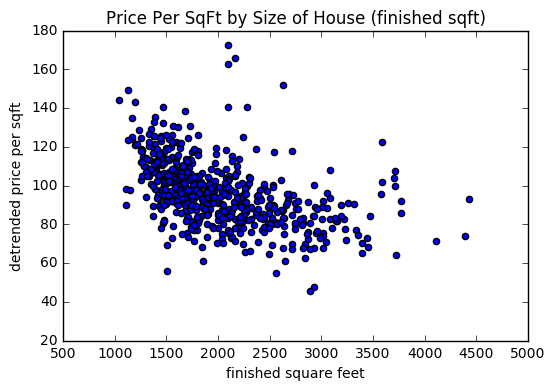

In [30]:
plt.scatter(df.finished_sqft.values, df.dtrend_price_per_finished_sqft.values)
plt.ylabel('detrended price per sqft')
plt.xlabel('finished square feet')
plt.title('Price Per SqFt by Size of House (finished sqft)')
plt.show()

### Identifying line that best fits the plot points

In [31]:
X = df.finished_sqft.values
y = df.dtrend_price_per_finished_sqft.values

for i in range(1,10):
    poly = preprocessing.PolynomialFeatures(i)
    X_poly = poly.fit_transform(X.reshape(-1, 1))
    model = linear_model.LinearRegression()
    model.fit(X_poly, y)
    print(i, model.score(X_poly, y))

1 0.243440380202
2 0.294356276844
3 0.296804272104
4 0.297383853531
5 0.295179673996
6 0.291747260713
7 0.286822602339
8 0.280478334664
9 0.272955851669


In [32]:
poly = preprocessing.PolynomialFeatures(4)
model = linear_model.LinearRegression()

X_trend = poly.fit_transform(X.reshape(-1, 1))
model.fit(X_trend,y)

sqft_range = np.array(range(int(min(X)),int(max(X))+1))
sqft_poly = poly.fit_transform(sqft_range.reshape(-1,1))
trend = model.predict(sqft_poly)

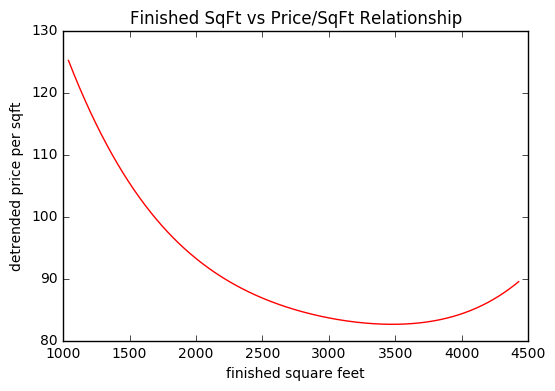

In [33]:
plt.plot(sqft_range, trend, color='r')
plt.ylabel('detrended price per sqft')
plt.xlabel('finished square feet')
plt.title('Finished SqFt vs Price/SqFt Relationship')
plt.show()

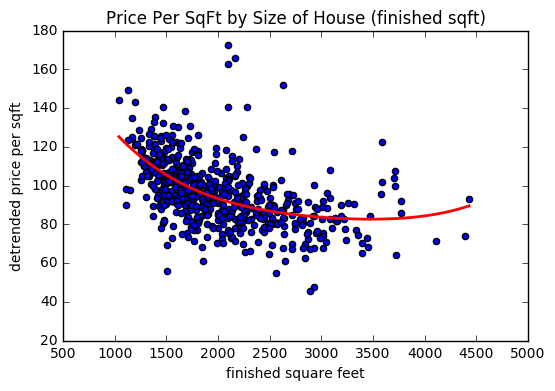

In [34]:
plt.scatter(X, y)
plt.plot(sqft_range, trend, color='r', lw=2)
plt.ylabel('detrended price per sqft')
plt.xlabel('finished square feet')
plt.title('Price Per SqFt by Size of House (finished sqft)')
plt.show()

### Adding ranges above and below best fit line

By examining the distance between all of the data points and the best fit line we can calculate the standard error. By using the standard error we can plot additional lines above and below the best fit line. We can also understand the percentage of points that fall between these lines.

The percentage of points that fall within each range is:
* Great: 16%
* Good: 25%
* OK, I guess 25%
* Junky: 16%

In [35]:
sq_error = (y - model.predict(X_trend)) ** 2
st_error = np.sqrt(np.sum(sq_error) / (len(y) - 1))

high_abv_avg = trend + st_error * 0.67449 * 2
high_avg = trend + st_error * 0.67449
low_avg = trend - st_error * 0.67449
low_bel_avg = trend - st_error * 0.67449 * 2

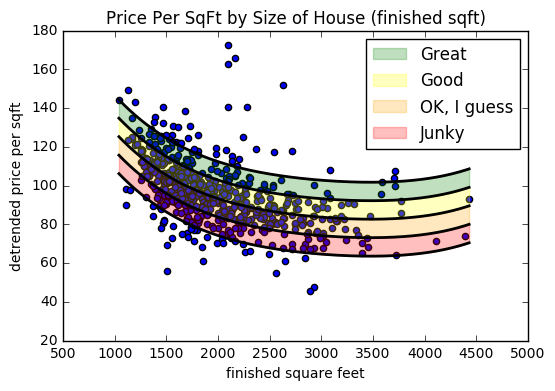

In [36]:
plt.scatter(X, y)
plt.plot(sqft_range, high_abv_avg, color='k', lw=2)
plt.plot(sqft_range, high_avg, color='k', lw=2)
plt.plot(sqft_range, trend, color='k', lw=2)
plt.plot(sqft_range, low_avg, color='k', lw=2)
plt.plot(sqft_range, low_bel_avg, color='k', lw=2)
plt.fill_between(sqft_range, high_abv_avg, high_avg, color='green', alpha=0.25)
plt.fill_between(sqft_range, high_avg, trend, color='yellow', alpha=0.25)
plt.fill_between(sqft_range, trend, low_avg, color='orange', alpha=0.25)
plt.fill_between(sqft_range, low_avg, low_bel_avg, color='red', alpha=0.25)
green_patch = mpatches.Patch(color='green', label='Great', alpha=0.25)
yellow_patch = mpatches.Patch(color='yellow', label='Good', alpha=0.25)
orange_patch = mpatches.Patch(color='orange', label='OK, I guess', alpha=0.25)
red_patch = mpatches.Patch(color='red', label='Junky', alpha=0.25)
plt.legend(handles=[green_patch, yellow_patch, orange_patch, red_patch])
plt.ylabel('detrended price per sqft')
plt.xlabel('finished square feet')
plt.title('Price Per SqFt by Size of House (finished sqft)')
plt.show()

### Price ranges at 1,533 FINISHED square feet

We can now calculate what the Great, Good, OK, and Junky ranges would be for a house based on 1,533 finished square feet.

In [38]:
target_sqft = 1533
poly_target = poly.fit_transform(target_sqft)
ppf_3 = model.predict(poly_target)[0]
ppf_1 = ppf_3 - st_error * 0.67449 * 2
ppf_2 = ppf_3 - st_error * 0.67449
ppf_4 = ppf_3 + st_error * 0.67449
ppf_5 = ppf_3 + st_error * 0.67449 * 2
price_1 = ppf_1 * target_sqft
price_2 = ppf_2 * target_sqft
price_3 = ppf_3 * target_sqft
price_4 = ppf_4 * target_sqft
price_5 = ppf_5 * target_sqft

levels = ['Junky','OK, I guess','Good','Great']
low_sqft = [ppf_1, ppf_2, ppf_3, ppf_4]
high_sqft = [ppf_2, ppf_3, ppf_4, ppf_5]
low_price = [price_1, price_2, price_3, price_4]
high_price = [price_2, price_3, price_4, price_5]
data = {'LEVEL': levels,'LOW PRICE PER SQFT': low_sqft, 'HIGH PRICE PER SQFT': high_sqft,
        'LOW PRICE': low_price, 'HIGH PRICE': high_price}

fin_sqft_ranges = pd.DataFrame(data)
fin_sqft_ranges = fin_sqft_ranges[['LEVEL','LOW PRICE PER SQFT','HIGH PRICE PER SQFT','LOW PRICE','HIGH PRICE']]
fin_sqft_ranges['LOW PRICE PER SQFT'] = fin_sqft_ranges['LOW PRICE PER SQFT'].apply(lambda x: '${:,.2f}'.format(x))
fin_sqft_ranges['HIGH PRICE PER SQFT'] = fin_sqft_ranges['HIGH PRICE PER SQFT'].apply(lambda x: '${:,.2f}'.format(x))
fin_sqft_ranges['LOW PRICE'] = fin_sqft_ranges['LOW PRICE'].apply(lambda x: '${:,.2f}'.format(x))
fin_sqft_ranges['HIGH PRICE'] = fin_sqft_ranges['HIGH PRICE'].apply(lambda x: '${:,.2f}'.format(x))
fin_sqft_ranges

,LEVEL,LOW PRICE PER SQFT,HIGH PRICE PER SQFT,LOW PRICE,HIGH PRICE
0,Junky,$85.25,$94.79,"$130,685.39","$145,309.37"
1,"OK, I guess",$94.79,$104.33,"$145,309.37","$159,933.36"
2,Good,$104.33,$113.87,"$159,933.36","$174,557.34"
3,Great,$113.87,$123.41,"$174,557.34","$189,181.32"


# Examine Other Factors as Determinants of Price

Let's go full out scientific on this by using machine learning to predict price based on multiple property features.

## Feature Engineering

### Creating Variables

In [39]:
# Age at Sale
df['age_at_sale'] = df.sales_date.apply(lambda x: x.year) - df.year_built

In [40]:
# Brick or Stone Veneer
df['has_veneer'] = 1
df.loc[(df['Add On - Brick Veneer'].isnull()) & (df['Add On - Nat Stone/moss Rock'].isnull()), 'has_veneer'] = 0

In [41]:
# Chain Link Fence
df['has_chain_link'] = 1
df.loc[df['Add On - Fence Chain Link'].isnull(), 'has_chain_link'] = 0

In [42]:
# Wood Fence
df['has_wood_fence'] = 1
df.loc[df['Add On - Fence Wood'].isnull(), 'has_wood_fence'] = 0

In [43]:
# Shed
df['has_shed'] = 1
df.loc[df['Add On - Shed'].isnull(), 'has_shed'] = 0

In [44]:
# Sprinkler System
df['has_sprinkler'] = 1
df.loc[df['Add On - Sprinkler System'].isnull(), 'has_sprinkler'] = 0

In [45]:
# Fireplace
df['has_fireplace'] = 1
df.loc[(df['Appliance - Fireplace Gas'].isnull()) & (df['Appliance - Fireplace Masonry'].isnull()) & \
       (df['Appliance - Fireplace Metal'].isnull()), 'has_fireplace'] = 0

In [46]:
# Walkout Basement
df['has_walkout'] = 1
df.loc[df['Basement - Walkout'].isnull(), 'has_walkout'] = 0

In [47]:
# Total Garage Capacity
fill_cols = ['Garage - Attached','Garage - Basement Double','Garage - Basement Single','Garage - Basement Triple',
             'Garage - Built In','Garage - Detached']
for col in fill_cols:
    df[col].fillna(0, inplace=True)
df['garage_sqft'] = df['Garage - Attached'] + df['Garage - Built In'] + df['Garage - Detached']
df['garage_capacity'] = 0
df.loc[(df.garage_sqft >    0) & (df.garage_sqft < 400), 'garage_capacity'] = 1
df.loc[(df.garage_sqft >= 400) & (df.garage_sqft < 700), 'garage_capacity'] = 2
df.loc[ df.garage_sqft >= 700, 'garage_capacity'] = 3
df['garage_capacity_basement'] = 0
df.loc[df['Garage - Basement Single'] == 1, 'garage_capacity_basement'] = 1
df.loc[df['Garage - Basement Double'] == 1, 'garage_capacity_basement'] = 2
df.loc[df['Garage - Basement Triple'] == 1, 'garage_capacity_basement'] = 3
df.garage_capacity = df.garage_capacity + df.garage_capacity_basement

In [48]:
# Deck
df['has_deck'] = 1
df.loc[(df['Porch - Cvrd Wood Deck'].isnull()) & (df['Porch - Wood Deck'].isnull()), 'has_deck'] = 0

In [49]:
# Finished Basement Square Feet
df['basement_fin_sqft'] = df.finished_sqft - df.square_feet

In [50]:
# Normal Deed
df['has_normal_deed'] = 0
df.loc[df['deed_type'] == 'WD', 'has_normal_deel'] = 1

In [51]:
# Poured Foundation
df['has_poured_foundation'] = 0
df.loc[df['foundation'] == 'Concrete', 'has_poured_foundation'] = 1

In [52]:
# Building Type
df['split_level'] = 0
df['tri_level'] = 0
df['ranch'] = 0
df['multi_level'] = 0
df['two_story'] = 0
df.loc[(df.built_as == 'Split Entry') | (df.built_as == 'Townhouse Split Level'), 'split_level'] = 1
df.loc[(df.built_as == 'Tri Level') | (df.built_as == '1 1/2 Story Fin'), 'tri_level'] = 1
df.loc[(df.built_as == 'Ranch') | (df.built_as == 'Raised Ranch'), 'ranch'] = 1
df.loc[df.built_as == 'Mult Level', 'multi_level'] = 1
df.loc[df.built_as == '2 Story', 'two_story'] = 1

In [53]:
df.quality.value_counts()

Average         530
Good             51
Average Plus     18
Fair Plus         1
Name: quality, dtype: int64

In [54]:
df.condition.value_counts()

Average      388
Good         189
Fair          17
Very Good      6
Name: condition, dtype: int64

In [55]:
# Average Quality and Condition (because there isn't much in the way of above and below average)
df['abv_avg_qual'] = 1
df['abv_avg_cond'] = 1
df.loc[(df.quality == 'Fair Plus') | (df.quality == 'Average') | (df.quality == 'Average Plus'), 'abv_avg_qual'] = 0
df.loc[(df.condition == 'Fair') | (df.condition == 'Average'), 'abv_avg_cond'] = 0

### Adding created variables to existing

In [56]:
continuous = ['detrended_price','square_feet','land_square_feet','age_at_sale','basement_fin_sqft']

discrete = ['rooms','baths','bedrooms','stories','garage_capacity']

nominal = ['has_veneer','has_chain_link','has_wood_fence','has_shed','has_sprinkler','has_fireplace','has_walkout',
           'has_deck','has_normal_deed','has_poured_foundation','split_level','tri_level','ranch','multi_level',
           'two_story','abv_avg_qual','abv_avg_cond']

ordinal = []

categorical = nominal + ordinal
numeric = continuous + discrete

### Adjusting skewed distributions if needed

#### Distribution skew before adjustment

In [57]:
df[continuous].skew().sort_values(ascending=False)

land_square_feet     2.138970
detrended_price      1.644499
basement_fin_sqft    0.981785
square_feet          0.834896
age_at_sale         -0.567824
dtype: float64

In [58]:
def best_skew_transforms(df, features):
    import operator
    no_trans = []
    mod_pos = []
    sev_pos = []
    sev_pos_0 = []
    mod_neg = []
    sev_neg = []
    for feature in features:
        maximum = df[feature].max()
        results = {}
        results['no_trans'] = abs(df[feature].skew())
        results['mod_pos'] = abs(df[feature].apply(lambda x: np.sqrt(x)).skew())
        results['sev_pos'] = abs(df[feature].apply(lambda x: np.log(x)).skew())
        results['sev_pos_0'] = abs(df[feature].apply(lambda x: np.log1p(x)).skew())
        results['mod_neg'] = abs(df[feature].apply(lambda x: np.sqrt(maximum - x)).skew())
        results['sev_neg'] = abs(df[feature].apply(lambda x: np.log(maximum - x)).skew())
        
        best_result = min(results.iteritems(), key=operator.itemgetter(1))[0]
        
        if best_result == 'mod_pos':
            mod_pos.append(feature)
        elif best_result == 'sev_pos':
            sev_pos.append(feature)
        elif best_result == 'sev_pos_0':
            sev_pos_0.append(feature)
        elif best_result == 'mod_neg':
            mod_neg.append(feature)
        elif best_result == 'sev_neg':
            sev_neg.append(feature)
        else:
            no_trans.append(feature)
            
        print('%s: %s' % (feature, best_result))
            
    return (no_trans, mod_pos, sev_pos, sev_pos_0, mod_neg, sev_neg)

In [59]:
def do_skew_transforms(df, mod_pos, sev_pos, sev_pos_0, mod_neg, sev_neg):
    for col in mod_pos:
        df[col] = df[col].apply(lambda x: np.sqrt(x))
    for col in sev_pos:
        df[col] = df[col].apply(lambda x: np.log(x))
    for col in sev_pos_0:
        df[col] = df[col].apply(lambda x: np.log1p(x))
    for col in mod_neg:
        df[col] = df[col].apply(lambda x: np.sqrt(df[col].max() - x))
    for col in sev_neg:
        df[col] = df[col].apply(lambda x: np.log(df[col].max() - x))

In [60]:
correct_skew_features = list(continuous)

no_trans, mod_pos, sev_pos, sev_pos_0, mod_neg, sev_neg = best_skew_transforms(df, correct_skew_features)

detrended_price: sev_pos
square_feet: sev_pos
land_square_feet: sev_pos
age_at_sale: mod_neg
basement_fin_sqft: mod_pos


In [61]:
do_skew_transforms(df, mod_pos, sev_pos, sev_pos_0, mod_neg, sev_neg)

#### Distribution skew after adjustment

In [62]:
df[continuous].skew().sort_values(ascending=False)

land_square_feet     0.918458
detrended_price      0.640040
square_feet          0.292276
age_at_sale         -0.311616
basement_fin_sqft   -0.976912
dtype: float64

## Building Regression Model

### Split into Train and Test Sets

In [63]:
train, test = cross_validation.train_test_split(df, test_size=0.25, random_state=9)

In [64]:
features = categorical + numeric
features.remove('detrended_price')
target = 'detrended_price'

In [65]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

### Random Model Selection Helper

In [66]:
class RandomSelectionHelper:
    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.random_searches = {}
    
    def fit(self, X, y, n_iter=60, cv=3, n_jobs=1, verbose=1, scoring=None, refit=True, random_state=None):
        for key in self.keys:
            print("Running RandomizedSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            rs = RandomizedSearchCV(model, params, n_iter=n_iter, cv=cv, n_jobs=n_jobs, 
                              verbose=verbose, scoring=scoring, refit=refit, random_state=random_state)
            rs.fit(X,y)
            self.random_searches[key] = rs
    
    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': np.min(scores),
                 'max_score': np.max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series(dict(params.items() + d.items()))
                      
        rows = [row(k, rsc.cv_validation_scores, rsc.parameters) 
                for k in self.keys
                for rsc in self.random_searches[k].grid_scores_]
        #df = pd.concat(rows, axis=1).T.sort([sort_by], ascending=False)
        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        
        return df[columns]

### Models to Search

In [67]:
models = { 
    'ExtraTreesRegressor': ensemble.ExtraTreesRegressor(),
    'AdaBoostRegressor': ensemble.AdaBoostRegressor(),
    'RandomForestRegressor': ensemble.RandomForestRegressor(),
    'Ridge': linear_model.Ridge(),
    'Lasso': linear_model.Lasso(),
    'ElasticNet': linear_model.ElasticNet()
}

### Parameters to Search

In [68]:
params = { 
    'ExtraTreesRegressor':       {'n_estimators': scipy.stats.randint(120, 1200),
                                  'max_depth': scipy.stats.randint(5, 30),
                                  'min_samples_split': scipy.stats.randint(1, 100),
                                  'min_samples_leaf': scipy.stats.randint(1, 10)},
    'AdaBoostRegressor':         {'n_estimators': scipy.stats.randint(120, 1200),
                                  'learning_rate': [0.0001,0.001,0.01,0.1,1,10]},
    'RandomForestRegressor':     {'n_estimators': scipy.stats.randint(120, 1200),
                                  'max_depth': scipy.stats.randint(5, 30),
                                  'min_samples_split': scipy.stats.randint(1, 100),
                                  'min_samples_leaf': scipy.stats.randint(1, 10)},
    'Ridge':                     {'alpha': scipy.stats.expon(scale=3)},
    'Lasso':                     {'alpha': scipy.stats.expon(scale=3)},
    'ElasticNet':                {'alpha': scipy.stats.expon(scale=3),
                                  'l1_ratio': scipy.stats.uniform(0,1)}
}

### Fit Models

In [69]:
evaluator = RandomSelectionHelper(models,params)
evaluator.fit(X_train, y_train, scoring='mean_squared_error', cv=10, n_iter=60, n_jobs=4)

Running RandomizedSearchCV for Ridge.
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=4)]: Done  48 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 600 out of 600 | elapsed:   12.6s finished


Running RandomizedSearchCV for ElasticNet.
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=4)]: Done  50 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done 600 out of 600 | elapsed:    9.5s finished


Running RandomizedSearchCV for AdaBoostRegressor.
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   47.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done 600 out of 600 | elapsed:  6.6min finished


Running RandomizedSearchCV for RandomForestRegressor.
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   44.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  5.8min
[Parallel(n_jobs=4)]: Done 600 out of 600 | elapsed:  8.0min finished


Running RandomizedSearchCV for ExtraTreesRegressor.
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   42.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done 600 out of 600 | elapsed:  6.6min finished


Running RandomizedSearchCV for Lasso.
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=4)]: Done  50 tasks      | elapsed:    7.8s
[Parallel(n_jobs=4)]: Done 600 out of 600 | elapsed:    9.5s finished


### Best Models

In [70]:
evaluator.score_summary(sort_by='mean_score').head()

,estimator,min_score,mean_score,max_score,std_score,alpha,l1_ratio,learning_rate,max_depth,min_samples_leaf,min_samples_split,n_estimators
51,Ridge,-0.0210263,-0.0146223,-0.0090717,0.00452009,0.483027,NaN,NaN,NaN,NaN,NaN,NaN
6,Ridge,-0.0210288,-0.0146223,-0.00907042,0.00452074,0.480426,NaN,NaN,NaN,NaN,NaN,NaN
19,Ridge,-0.0210512,-0.0146224,-0.00905912,0.0045265,0.457676,NaN,NaN,NaN,NaN,NaN,NaN
42,Ridge,-0.0210638,-0.0146224,-0.00905276,0.00452977,0.444915,NaN,NaN,NaN,NaN,NaN,NaN
52,Ridge,-0.0210743,-0.0146225,-0.00904752,0.00453247,0.434444,NaN,NaN,NaN,NaN,NaN,NaN


### Feature Importance from Best Model

Positive coefficients add value to a property. Negative coefficients decrease value. Features are ordered by the magnitude to which they add to property value.

In [71]:
best_model = evaluator.random_searches['Ridge'].best_estimator_
best_model

Ridge(alpha=0.48302674256809291, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

In [72]:
pd.DataFrame(dict(zip(features,best_model.coef_)), index=['coef']).transpose().sort_values('coef', ascending=False)

,coef
square_feet,0.416579
abv_avg_qual,0.187892
abv_avg_cond,0.080770
land_square_feet,0.051786
age_at_sale,0.039310
baths,0.031025
has_sprinkler,0.023921
multi_level,0.023543
ranch,0.020556
two_story,0.020015


### Test the Best Model on the Test Set

In [73]:
test_pred = best_model.predict(X_test)

In [74]:
print('mean squared error: %.5f' % metrics.mean_squared_error(y_test, test_pred))

mean squared error: 0.01677


In [75]:
compare = pd.DataFrame({'prediction': test_pred, 'actual': y_test.values}, index=range(len(test_pred)))
compare = compare.apply(lambda x: np.exp(x))
compare.head(20)

,actual,prediction
0,255331.822638,228323.384509
1,151408.849993,157507.192541
2,220174.202700,197005.130556
3,121633.915308,145596.526829
4,262030.106923,239563.481267
5,247609.534081,238092.557450
6,197874.032154,185951.930290
7,324459.888325,301656.679475
8,176518.857819,192436.033588
9,190323.131938,169631.687695


## Applying Model to 13416 Trendwood Dr

Now that we have a pretty good model we can use it as our "best fit line" as before and then build Junky, OK, Good, and Great ranges off of it.

In [76]:
X = df[features].values
y = np.exp(df[target].values)
pred = np.exp(best_model.predict(X))

sq_error = (y - pred) ** 2
st_error = np.sqrt(np.sum(sq_error) / (len(y) - 1))

In [78]:
target_property = df.loc[df.parcel_address == '13416  TRENDWOOD DR OMAHA NE 68144-0000', features]
sq_ft = np.exp(target_property.square_feet.values[0])
price_3 = np.exp(best_model.predict(target_property.values)[0])
price_1 = price_3 - st_error * 0.67449 * 2
price_2 = price_3 - st_error * 0.67449
price_4 = price_3 + st_error * 0.67449
price_5 = price_3 + st_error * 0.67449 * 2
ppf_1 = price_1 / sq_ft
ppf_2 = price_2 / sq_ft
ppf_3 = price_3 / sq_ft
ppf_4 = price_4 / sq_ft
ppf_5 = price_5 / sq_ft

levels = ['Junky','OK, I guess','Good','Great']
low_sqft = [ppf_1, ppf_2, ppf_3, ppf_4]
high_sqft = [ppf_2, ppf_3, ppf_4, ppf_5]
low_price = [price_1, price_2, price_3, price_4]
high_price = [price_2, price_3, price_4, price_5]
data = {'LEVEL': levels,'LOW PRICE PER SQFT': low_sqft, 'HIGH PRICE PER SQFT': high_sqft,
        'LOW PRICE': low_price, 'HIGH PRICE': high_price}

reg_ranges = pd.DataFrame(data)
reg_ranges = reg_ranges[['LEVEL','LOW PRICE PER SQFT','HIGH PRICE PER SQFT','LOW PRICE','HIGH PRICE']]
reg_ranges['LOW PRICE PER SQFT'] = reg_ranges['LOW PRICE PER SQFT'].apply(lambda x: '${:,.2f}'.format(x))
reg_ranges['HIGH PRICE PER SQFT'] = reg_ranges['HIGH PRICE PER SQFT'].apply(lambda x: '${:,.2f}'.format(x))
reg_ranges['LOW PRICE'] = reg_ranges['LOW PRICE'].apply(lambda x: '${:,.2f}'.format(x))
reg_ranges['HIGH PRICE'] = reg_ranges['HIGH PRICE'].apply(lambda x: '${:,.2f}'.format(x))
reg_ranges

,LEVEL,LOW PRICE PER SQFT,HIGH PRICE PER SQFT,LOW PRICE,HIGH PRICE
0,Junky,$105.49,$120.13,"$116,463.72","$132,627.30"
1,"OK, I guess",$120.13,$134.77,"$132,627.30","$148,790.89"
2,Good,$134.77,$149.42,"$148,790.89","$164,954.48"
3,Great,$149.42,$164.06,"$164,954.48","$181,118.06"


## Average the Estimates

Each of the evaluation methods provided pretty similar estimates. We'll average the three to come up with a consensus estimate.

In [80]:
base_sqft_ranges.replace(to_replace='\$', value='', inplace=True, regex=True)
fin_sqft_ranges.replace(to_replace='\$', value='', inplace=True, regex=True)
reg_ranges.replace(to_replace='\$', value='', inplace=True, regex=True)

base_sqft_ranges.replace(to_replace='\,', value='', inplace=True, regex=True)
fin_sqft_ranges.replace(to_replace='\,', value='', inplace=True, regex=True)
reg_ranges.replace(to_replace='\,', value='', inplace=True, regex=True)

base_sqft_ranges = base_sqft_ranges.convert_objects(convert_numeric=True)
fin_sqft_ranges = fin_sqft_ranges.convert_objects(convert_numeric=True)
reg_ranges = reg_ranges.convert_objects(convert_numeric=True)

C:\Users\jdoyle\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Users\jdoyle\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Users\jdoyle\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:11: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [82]:
ranges = (base_sqft_ranges.iloc[:,1:] + fin_sqft_ranges.iloc[:,1:] + reg_ranges.iloc[:,1:]) / 3
ranges['LEVEL'] = reg_ranges['LEVEL']
ranges = ranges[['LEVEL','LOW PRICE','HIGH PRICE']]
ranges['LOW PRICE'] = ranges['LOW PRICE'].apply(lambda x: '${:,.2f}'.format(x))
ranges['HIGH PRICE'] = ranges['HIGH PRICE'].apply(lambda x: '${:,.2f}'.format(x))
ranges

,LEVEL,LOW PRICE,HIGH PRICE
0,Junky,"$125,152.53","$139,881.70"
1,OK I guess,"$139,881.70","$154,610.88"
2,Good,"$154,610.88","$169,340.06"
3,Great,"$169,340.06","$184,069.23"


## Price Conclusion

Looking at pictures of houses that have sold in the target neighborhoods, it seems evident that our property would be considered by buyers to be on the upper end of "Good"...not the lower end of "OK, I guess". It's definitely above average in aesthetics, character, and lot location and it has all new appliances, HVAC, water heater, and roof...but the house probably wouldn't be considered "Great" by most.

Accordingly, based on the average of the three estimates, a reasonable list price would be <b>\$165,000 - $170,000</b>.